In [1]:
import sys, os
sys.path.append('../src')
import numpy as np
from scipy.optimize import differential_evolution
from numba import jit
import time, multiprocessing, pickle
from scipy.integrate import quad
from NeutrinoFogFuncs import phiGen3

from NeutrinoFuncs import BinnedNeutrinoRates, BinnedNeutrinoRates2
from WIMPFuncs import BinnedWIMPRate,MeanInverseSpeed_SHM,C_SI, BinnedWIMPRate2
from LabFuncs import FormFactorHelm
from Params import *
#==============================================================================#
ne = 50 # number of energy bins (anything >50 is accurate enough)
nm = 200 # number of mass points
Flux_norm = NuFlux # See Params.py
Flux_err = NuUnc # See Params.py
E_th = 1.0e-4 # Threshold
E_max = 200.0 # Max recoil energy

Nuc = Xe131

In [2]:
def matOneHalfGen(mat):
    va, ve = np.linalg.eigh(mat)
    if np.any(va<0.):
        return [1.]
    return [ve@np.diag(1/va)@np.transpose(ve), ve@np.diag(np.sqrt(va))@np.transpose(ve)]

def symMatGen(diagTerms, ijTerms):
    n = len(diagTerms)
    myMat = np.zeros((n,n))
    for i in range(0, n-1):
        myMat[i, i+1:] = ijTerms[i]
        myMat[i+1:, i] = ijTerms[i]
    myMat = myMat + np.diag(diagTerms)
    return myMat
    
def myMatGen(thetaPrime, s, b, deriWA, deri2WA, sigmaTheta, sigmaWA):
    n = len(b) + 2
    
    deriWATotal = np.sum(deriWA,axis=0)
    vList = thetaPrime[0]*s + np.sum(b, axis=0)
    vInvList = 1/vList
    deriList = np.vstack((s,b,deriWATotal))
    deriNuListT = np.transpose(deriList[1:])
    
    sigmaWA2 = sigmaWA*sigmaWA
    sigmaTheta2 = np.append(sigmaTheta,[sigmaWA])**2

    tempVar1 = 0.5*sigmaWA2*deri2WA*vInvList
    tempVar2 = np.array([tempVar1@deriWA[i] for i in range(len(deriWA))])
    temp = vInvList*(1 + tempVar1)
    tempMat = np.zeros((n,n))
    tempMat[-1,-1] = tempVar1@deri2WA
    tempMat[-1,1:-1] = tempVar2
    tempMat[1:-1,-1] = tempVar2
    ijList = [[np.sum(deriList[i]*deriList[j]*temp) for j in range(i+1,n)] for i in range(0,n-1)]
    diagTerms = np.array([np.sum(deriList[i]*deriList[i]*temp) for i in range(0,n)])
    lddTemp = symMatGen(diagTerms, ijList)
    lddTempDiag = np.append([0.],1/(sigmaTheta2))
    muTemp = np.array([np.sum(tempVar1*deri) for deri in deriList])

    nBin = len(vList)
    ijTerms = [[np.sum(deriNuListT[i]*deriNuListT[j]*sigmaTheta2) for j in range(i+1,nBin)] for i in range(0,nBin-1)]
    diagTerms = [np.sum(deriNuListT[i]*deriNuListT[i]*sigmaTheta2) for i in range(0,nBin)]
    varGauTermConst = np.outer(vInvList, vInvList)*(symMatGen(diagTerms, ijTerms) \
                     - (0.5*sigmaWA2)**2*np.outer(deri2WA, deri2WA))
    
    n = len(b) + 1
    deriList = np.vstack((s,b))
    varGauTermIJ = [[np.sum(np.outer(deriList[i], deriList[j])*varGauTermConst)\
                             for j in range(i+1,n)] for i in range(0,n-1)]
    varGauTermDiag = [np.sum(np.outer(deriList[i], deriList[i])*varGauTermConst)\
                             for i in range(0,n)]
    varGauTerm = symMatGen(varGauTermDiag, varGauTermIJ)
    
    return [lddTemp, tempMat, varGauTerm, lddTempDiag, muTemp]

class WMA(object):
    
    def __init__(self, E_th, E_max, ne, selList=[]):
        nunames, NuUnc, RNuSM = BinnedNeutrinoRates2(E_th,E_max,ne,Nuc,Flux_norm)
        if len(selList) == 0:
            selList = np.linspace(0,len(NuUnc)-1,len(NuUnc),dtype=int)
        else:
            self._selList = selList
        RNuSM = RNuSM[selList]
        iEnd = np.max([len(x[x>1.0e-10]) for x in RNuSM])
        self._RNuSM, self._NuUnc = RNuSM[:,:iEnd], NuUnc[selList]
        # derivation of weak-mixing angle
        N = Nuc.NumberOfNeutrons
        Z = Nuc.NumberOfProtons
        sinTheta_Wsq = 0.2387
        Q_W = 1.0*N-(1-4.0*sinTheta_Wsq)*Z # weak nuclear hypercharge
        self._RNuSMDeri1 = 8*sinTheta_Wsq*Z/Q_W*self._RNuSM
        self._RNuSMDeri2 = 32*(sinTheta_Wsq*Z/Q_W)**2*np.sum(self._RNuSM,axis=0)
        self._deriFactor = 8*sinTheta_Wsq*Z/Q_W
        
        self._temp = [E_th, E_max, ne, Nuc, C_SI, iEnd]
        return None
    
    def _sGen(self, mDM):
        E_th, E_max, ne, Nuc, C_SI, iEnd = self._temp
        dd = 1.0e-4
        xList = np.array([-1.,0,1.])*dd + 1.
        m = np.array([mDM])
        y = BinnedWIMPRate2(E_th, E_max, ne,m,Nuc,C_SI,FormFactorHelm,\
                                      lambda v_min: MeanInverseSpeed_SHM(v_min,sig_v=167.0*1,v_esc=533.0,v_lab=245.6))[1][0][:iEnd]
        return y
    
    def setDMMass(self, mDM):
        self._RWIMP = self._sGen(mDM)
        return 
        
    def tempMatSet(self, sigma0, sigmaWA):
        thetaPrime = np.array([1.])
        RNuSM, NuUncs = self._RNuSM, self._NuUnc
        RWIMP = self._RWIMP*10**(sigma0+45.)
        deriWA, deri2WA = self._RNuSMDeri1, self._RNuSMDeri2
        
        s, b, sigmaTheta = RWIMP, RNuSM, NuUncs
        #lddTemp, varGauTerm = myMatGen(thetaPrime, s1, s2, b, sigmaTheta)
        self._tempMat = myMatGen(thetaPrime, s, b, deriWA, deri2WA, sigmaTheta, sigmaWA)
        return 
    
    def distributionPara(self, exposure):
        lddTemp, tempMat, varGauTerm, lddTempDiag, muTemp = self._tempMat
        ldd = exposure*(lddTemp-tempMat) + np.diag(lddTempDiag)
        mu = exposure*muTemp
        varMat = exposure*lddTemp[:-1,:-1] + exposure**2*varGauTerm
        n = len(mu)
        nk = n - 1
        G3 = ldd.copy()[1:,1:]
        HMat = np.block([[np.zeros((1,1)), np.zeros((1,nk))],[np.zeros((nk,1)), np.linalg.inv(G3)]])
        
        temp = matOneHalfGen(ldd)
        if len(temp)==1:
            return [1]
        lddInv, lddOneHalf = temp
        
        temp = matOneHalfGen(varMat)
        if len(temp)==1:
            return [2]
        varMatInv, varMatOneHalf = temp
        varMatOneHalfInv = np.linalg.inv(varMatOneHalf)
        
        tranMat = np.vstack((np.eye(nk), np.append([0.],self._deriFactor*np.ones(nk-1))))
        #print(tranMat)
        tMat = np.transpose(tranMat)@(lddInv - HMat)@tranMat
        ldd = ldd[:-1,:-1]
        mu = mu[:-1]
        delta = np.append([1.],np.zeros(nk-1))
        
        #tmat = lddInv - HMat
        res1 = varMatOneHalf@tMat@varMatOneHalf
        res2 = np.linalg.eigh(res1)
        orderList = np.flip(np.argsort(res2[0]))
        res2 = [res2[0][orderList], np.transpose(res2[1])[orderList]]
        res3 = varMatOneHalfInv@(mu+ldd@delta)
        #print('1: ', res2[0][:5])
        return [res2[0][0:2], res2[1][0:2], (res2[1][0:2]@res3)**2, res2[0]]
    
    def phiAsiGen(self,sigmaWA,sigma0,exposure):
        lddTemp, tempMat, varGauTerm, lddTempDiag, muTemp = self._tempMat
        ldd = exposure*(lddTemp-tempMat) + np.diag(lddTempDiag)
        mu = exposure*muTemp
        #varMat = exposure*lddTemp[:-1,:-1] + exposure**2*varGauTerm
        n = len(mu)
        nk = n - 1
        G3 = ldd.copy()[1:,1:]
        HMat = np.block([[np.zeros((1,1)), np.zeros((1,nk))],[np.zeros((nk,1)), np.linalg.inv(G3)]])
        
        s, b, sigmaTheta = self._RWIMP*10**(sigma0+45.), self._RNuSM, self._NuUnc
        sigmaTheta = np.append(sigmaTheta,[sigmaWA])
        niuList = (-(np.append([1.],np.zeros(n-1)) - HMat@ldd@np.append([1.],np.zeros(n-1))))[1:] + 1.
        #print((-(np.append([1.],np.zeros(n-1)) - HMat@ldd@np.append([1.],np.zeros(n-1)))) + 1.)
        datObs = s + np.sum(b,axis=0)
        temp = niuList[:-1]@b*RNuFactorGen(niuList[-1])
        phi = 2*(-exposure*np.sum(datObs*(np.log(temp)-np.log(datObs))-(temp-datObs))+ 0.5*np.sum(((1-niuList)/sigmaTheta)**2))
        return phi
    
    def H1Func(self, datObs, nuiList, sigmaWA, exposure, sigma0):
        thetaPrime = np.array([1.])
        RNuSM, NuUncs = self._RNuSM, self._NuUnc
        RWIMP = self._RWIMP*10**(sigma0+45.)
        Uncs = np.append(NuUncs,[sigmaWA])
        RNuSM = np.transpose(np.ascontiguousarray(np.transpose(RNuSM)))
        return H1Func(datObs, RNuSM, RWIMP, nuiList[0], nuiList[1:], Uncs, exposure)
    
# To collect the test statistic generated from MC pseudo-experiments
@jit(nopython=True)
def H0Func(datObs, RNu, nuiList, Uncs, exposure):
    temp = nuiList[:-1]@RNu*RNuFactorGen(nuiList[-1])
    return - exposure*np.sum(datObs*(np.log(exposure)+np.log(temp))-temp)+ 0.5*np.sum(((1-nuiList)/Uncs)**2)

@jit(nopython=True)
def H1Func(datObs, RNu, RWIMP, mu, nuiList, Uncs, exposure):
    temp = nuiList[:-1]@RNu*RNuFactorGen(nuiList[-1]) + RWIMP*mu
    return - exposure*np.sum(datObs*(np.log(exposure)+np.log(temp))-temp) + 0.5*np.sum(((1-nuiList)/Uncs)**2)
    
class MCCheck(object):
    
    def __init__(self, mDM, E_th, E_max, ne):
        self._mDM, self._E_th, self._E_max, self._ne= mDM, E_th,E_max,ne
        nunames, self._NuUnc, self._R_nu = BinnedNeutrinoRates2(E_th,E_max,ne,Nuc,Flux_norm)
        self._RWIMP = BinnedWIMPRate2(E_th,E_max,ne,np.array([mDM]),Nuc,C_SI,\
                                      FormFactorHelm,MeanInverseSpeed_SHM)[1][0]
        #print('Neutrino sources: ', np.array(nunames))
        return None
    
    def _datGenH0(self, RNu, Uncs, exposure):
        for i in range(100):
            nuiList = np.array(list(map(lambda d: np.random.normal(loc=1.,scale=d), Uncs)))
            if np.all(nuiList>np.zeros(len(nuiList))):
                break
        dat = nuiList[:-1]@RNu*RNuFactorGen(nuiList[-1])
        return np.array(list(map(lambda d: np.random.poisson(lam=d), dat*exposure)))/exposure
    
    def _datGenH1(self, RNu, RWIMP, Uncs, exposure):
        for i in range(100):
            nuiList = np.array(list(map(lambda d: np.random.normal(loc=1.,scale=d), Uncs)))
            if np.all(nuiList>np.zeros(len(nuiList))):
                break
        dat = nuiList[:-1]@RNu*RNuFactorGen(nuiList[-1]) + RWIMP
        return np.array(list(map(lambda d: np.random.poisson(lam=d), dat*exposure)))/exposure
    
    def _statisticGen(self, datObs, RNu, RWIMP, Uncs, exposure):
        n = np.shape(Uncs)[0]
        H0Gen = lambda x: H0Func(datObs, RNu, x, Uncs, exposure)
        H1Gen = lambda x: H1Func(datObs, RNu, RWIMP, x[0], x[1:], Uncs, exposure)

        boundsH0 = np.transpose([np.zeros(n)+1.0e-5, np.ones(n)*3.])
        boundsH1 = np.transpose([np.zeros(n+1)+1.0e-5, \
                                 np.append(np.array([1.0e2]),np.ones(n)*3.)])
        likeDeno = differential_evolution(H1Gen, boundsH1, tol=0, atol=0.01)
        likeNume = differential_evolution(H0Gen, boundsH0, tol=0, atol=0.01)
        #print(likeDeno," ",likeNume," ",[datDM])
        return [2*(likeNume.fun-likeDeno.fun), likeNume.x, likeDeno.x, datObs] 
    
    def H0StatGen(self, sigma0, exposure, sigmaWA, selList, n):
        RNu = self._R_nu[selList]
        NuUncs = self._NuUnc[selList]
        Uncs = np.append(NuUncs, [sigmaWA])
        iEnd = np.max([len(x[x>1.0e-10]) for x in RNu])
        RNu = RNu[:,:iEnd]
        RWIMP = self._RWIMP[:iEnd]*10**(sigma0+45.)
        #datDM = self._sigGen(1.)[:iEnd]*10**(sigma0+45.)
        
        datObsList = np.array(list(map(lambda i: \
                self._datGenH0(RNu, Uncs, exposure), range(n))))
        RNu = np.transpose(np.ascontiguousarray(np.transpose(RNu)))
        time_start = time.perf_counter()
        pool = multiprocessing.Pool(4)
        multiple_results = [pool.apply_async(\
                self._statisticGen, (datObsList[i], RNu, RWIMP, Uncs, exposure))\
                                             for i in range(n)]
        pool.close()
        pool.join()
        H0Stat= [res.get() for res in multiple_results]
        #H1Stat = [self._statisticGen(datObsList[i], RNu, sigma0, Uncs, exposure) for i in range(n)]
        time_end = time.perf_counter()
        print("Time costed: {0} s.".format(time_end-time_start))
        return H0Stat
    
    def H1StatGen(self, sigma0, exposure, sigmaWA, selList, n):
        RNu = self._R_nu[selList]
        NuUncs = self._NuUnc[selList]
        Uncs = np.append(NuUncs, [sigmaWA])
        iEnd = np.max([len(x[x>1.0e-10]) for x in RNu])
        RNu = RNu[:,:iEnd]
        RWIMP = self._RWIMP[:iEnd]*10**(sigma0+45.)
        #datDM = self._sigGen(1.)[:iEnd]*10**(sigma0+45.)
        
        datObsList = np.array(list(map(lambda i: \
                self._datGenH1(RNu, RWIMP, Uncs, exposure), range(n))))
        
        RNu = np.transpose(np.ascontiguousarray(np.transpose(RNu)))
        time_start = time.perf_counter()
        pool = multiprocessing.Pool(4)
        multiple_results = [pool.apply_async(\
                self._statisticGen, (datObsList[i], RNu, RWIMP, Uncs, exposure))\
                                             for i in range(n)]
        pool.close()
        pool.join()
        H1Stat= [res.get() for res in multiple_results]
        #H1Stat = [self._statisticGen(datObsList[i], RNu, sigma0, Uncs, exposure) for i in range(n)]
        time_end = time.perf_counter()
        print("Time costed: {0} s.".format(time_end-time_start))
        return H1Stat
    
@jit(nopython=True)
def RNuFactorGen(theta2):
    N, Z = 77, 54
    sinTheta_Wsq = 0.2387
    Q_W = 1.0*N-(1-4.0*sinTheta_Wsq)*Z # weak nuclear hypercharge
    return ((1.0*N-(1-4.0*sinTheta_Wsq*theta2)*Z)/Q_W)**2

In [3]:
Eth = E_th
sigmaWA = 0.1

In [4]:
# np.argsort(np.abs(tempPara[1][0][2:]))[::-1] shows the order of impacts from different neutrino sources
mDM = 0.2
sigma0 = -44.3
exposure = 1.0e1
WMA2 = WMA(Eth, E_max, ne)
WMA2.setDMMass(mDM)
WMA2.tempMatSet(sigma0, sigmaWA)
tempPara=WMA2.distributionPara(exposure,)
[tempPara,np.argsort(np.abs(tempPara[1][0][1:-1]))[::-1]]

[[array([1.31874982e+00, 5.99700930e-13]),
  array([[ 3.53603265e-01,  2.12299532e-01, -3.43226877e-01,
          -5.43806932e-03,  6.40245764e-02, -6.05162601e-01,
          -5.76966308e-01,  8.31943453e-02, -3.78637005e-02,
          -6.60136054e-04, -8.61627602e-04, -8.70591267e-03,
           1.31249735e-02,  1.28506128e-02, -8.83782268e-03,
          -9.46886162e-04],
         [ 2.00830626e-01, -3.97935539e-01, -1.33460527e-01,
           4.52030592e-01,  3.83153654e-02,  5.54505888e-01,
          -5.16873243e-01,  5.23743091e-02, -8.04775912e-03,
           6.99879612e-04, -1.61416108e-03, -8.35005856e-03,
           9.73088456e-03,  7.97638900e-03, -5.37482108e-03,
           5.88593171e-04]]),
  array([8.61099077, 0.6987791 ]),
  array([ 1.31874982e+00,  5.99700930e-13,  1.09090090e-13,  1.22988378e-14,
          2.83745933e-15,  1.87944709e-16,  3.64153748e-17,  7.97197384e-18,
          1.13793852e-18,  3.61418518e-19, -1.52095248e-17, -1.63837198e-16,
         -4.73650406e-1

In [5]:
selList2 = np.array([0,1,4,5,7])
MC2 = MCCheck(mDM, Eth, E_max, ne)
WMA2 = WMA(Eth, E_max, ne, selList2)
WMA2.setDMMass(mDM)
WMA2.tempMatSet(sigma0, sigmaWA)
tempPara=WMA2.distributionPara(exposure)
tempPara

[array([1.31879208e+00, 1.18331835e-10]),
 array([[ 0.39864573,  0.18954304, -0.34269468, -0.5971492 , -0.5754243 ,
          0.00388179],
        [ 0.15598583,  0.87093292,  0.01016122,  0.45507414, -0.08298607,
          0.05533406]]),
 array([8.79583026, 1.11486181]),
 array([ 1.31879208e+00,  1.18331835e-10,  2.44109156e-14, -1.70309895e-14,
        -4.29372114e-13, -1.48929299e-12])]

In [6]:
mDM = 0.51
sigma0 = -44.1
exposure = 1.0e1
sigmaWA = 0.1
WMA51 = WMA(Eth, E_max, ne)
WMA51.setDMMass(mDM)
WMA51.tempMatSet(sigma0, sigmaWA)
tempPara=WMA51.distributionPara(exposure,)
[tempPara,np.argsort(np.abs(tempPara[1][0][1:-1]))[::-1]]

[[array([2.9160317e+00, 1.9055473e-11]),
  array([[ 4.86524403e-01, -7.91486044e-01, -1.53085862e-02,
          -2.53195834e-04,  3.43069125e-02, -2.88090447e-01,
          -1.23606733e-01,  1.90931142e-01,  1.72051466e-02,
           3.17360101e-04, -8.56793728e-05, -8.52861206e-04,
          -1.14272808e-02, -6.91766232e-03,  1.33409668e-02,
          -7.05438584e-03],
         [ 6.41925121e-01,  2.27875145e-01,  1.33558805e-01,
          -7.11189419e-03,  4.67625753e-02,  6.62952333e-01,
          -6.75298660e-02,  2.59717579e-01,  6.14981733e-02,
           2.83879371e-03, -6.48588909e-04, -2.17519878e-03,
          -9.98963333e-03, -6.54119725e-03,  2.09157831e-02,
          -5.93293452e-03]]),
  array([4.68012611, 9.04859878]),
  array([ 2.91603170e+00,  1.90554730e-11,  8.30818866e-14,  4.78140172e-14,
          1.41026522e-14,  2.02395783e-15,  3.16624199e-16,  6.85162968e-17,
          6.08619743e-18, -5.72558786e-18, -1.03067686e-17, -3.38693831e-17,
         -3.05645465e-16,

In [7]:
selList51 = np.array([0,4])
MC51 = MCCheck(mDM, Eth, E_max, ne)
WMA51 = WMA(Eth, E_max, ne, selList51)
WMA51.setDMMass(mDM)
WMA51.tempMatSet(sigma0, sigmaWA)
tempPara=WMA51.distributionPara(exposure)
tempPara

[array([2.7907795e+00, 2.7643254e-11]),
 array([[ 0.54832302, -0.79849187, -0.24850072],
        [ 0.67836768,  0.25092759,  0.69054517]]),
 array([4.85967188, 8.83762136]),
 array([2.7907795e+00, 2.7643254e-11, 2.2855513e-12])]

In [8]:
mDM = 5.5
sigma0 = -45.5
exposure = 1.0e1
WMA55 = WMA(Eth, E_max, ne)
WMA55.setDMMass(mDM)
WMA55.tempMatSet(sigma0, sigmaWA)
tempPara=WMA55.distributionPara(exposure,)
[tempPara,np.argsort(np.abs(tempPara[1][0][1:-1]))[::-1]]

[[array([9.98882119e-01, 4.81773177e-12]),
  array([[ 1.41582189e-01, -2.87502360e-02, -5.60655976e-02,
          -1.61193269e-02, -1.23028652e-03, -6.62905560e-03,
           9.86256729e-01,  1.10710896e-02, -1.56794757e-02,
          -4.59398562e-04,  4.13647451e-04, -1.44078297e-03,
          -2.95995436e-02, -9.30774334e-03,  1.25025719e-03,
          -4.05182203e-02],
         [-1.48770311e-02,  9.95105991e-01,  1.90092806e-03,
           9.04840288e-02,  6.07173377e-03,  1.30525383e-02,
           3.28292143e-02,  1.09638193e-03, -3.27316751e-03,
          -7.22471845e-05,  2.83262762e-03,  6.51896157e-03,
           1.95364160e-03,  6.89319590e-04, -1.37272154e-04,
          -1.50004237e-04]]),
  array([8.91478925, 0.00948731]),
  array([ 9.98882119e-01,  4.81773177e-12,  5.13135371e-14,  1.44692849e-14,
          7.40301557e-16,  2.18836879e-16,  8.86014875e-17,  3.57381770e-17,
          2.59091881e-18, -4.77044084e-20, -1.33904761e-18, -7.61563613e-18,
         -7.02423771e-1

In [9]:
selList55 = np.array([5,1])
MC55 = MCCheck(mDM, Eth, E_max, ne)
WMA55 = WMA(Eth, E_max, ne, selList55)
WMA55.setDMMass(mDM)
WMA55.tempMatSet(sigma0, sigmaWA)
tempPara=WMA55.distributionPara(exposure)
tempPara

[array([9.96411999e-01, 9.41922649e-13]),
 array([[ 0.16075848,  0.82381273, -0.54358928],
        [ 0.04014574,  0.54483896,  0.83757914]]),
 array([7.22768816, 0.08746973]),
 array([9.96411999e-01, 9.41922649e-13, 4.40779454e-16])]

In [10]:
labelList = [2,51,55]
selList = [eval('selList'+str(i)) for i in labelList]
MCList = [eval('MC'+str(i)) for i in labelList]
WMAList = [eval('WMA'+str(i)) for i in labelList]
sigma0List = [-44.3,-44.1,-45.5]
exposureList = [10.,10.,10.]

In [11]:
distributionParaList = np.array([[WMAList[i].distributionPara(exposureList[i])[0][0],\
                         WMAList[i].phiAsiGen(sigmaWA,\
            sigma0List[i],exposureList[i])] for i in range(len(WMAList))])
distributionParaList

array([[ 1.31879208, 10.39530751],
       [ 2.7907795 , 14.51607273],
       [ 0.996412  ,  7.08878992]])

In [12]:
H1DatList = [MCList[i].H1StatGen(sigma0List[i], exposureList[i], sigmaWA,\
                        selList[i], 10000) for i in range(len(MCList))]

Time costed: 4772.818101165816 s.
Time costed: 1201.3399433400482 s.
Time costed: 988.0160823613405 s.


In [13]:
mypath = os.path.join(os.path.abspath(os.path.pardir),'data', 'MC')
myData = H1DatList
myFile = open(os.path.join(mypath,'MCWMAH1.pickle'), 'wb')
pickle.dump(myData, myFile)
myFile.close()

In [14]:
i=2
H0Dat = MCList[i].H0StatGen(sigma0List[i], exposureList[i], sigmaWA,\
                        selList[i], 1000)

Time costed: 106.89918366307393 s.


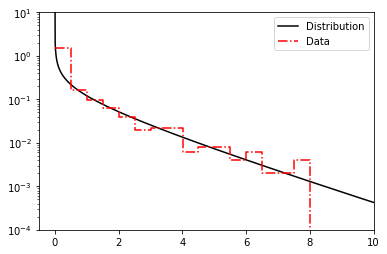

In [15]:
from scipy.stats import ncx2
import matplotlib.pyplot as plt

def H0StatPlot(H0Stat, xmax):
    dmax=500.
    H0Stat = np.array(list(map(lambda x: 1.0e-6 if x<0. else x, H0Stat)))
    H0StatX = np.linspace(0.,dmax,1000)
    DatX = np.array(list(map(lambda x: [x,x], H0StatX[1:-1]))).flatten()
    DatX = np.append([H0StatX[0]], np.append(DatX, [H0StatX[-1]]))
    H0StatY = np.histogram(H0Stat, bins=H0StatX)[0]
    H0StatY = 1/(np.sum(H0StatY)*(H0StatX[1]-H0StatX[0]))*H0StatY
    DatY = np.array(list(map(lambda x: [x,x], H0StatY))).flatten()
    
    fig, ax = plt.subplots()
    x = np.linspace(1.0e-6,xmax,1000)
    y = 0.5*ncx2.pdf(x,df=1,nc=0)
    ax.plot(x, y, color='black', linestyle='-', label='Distribution')
    ax.plot(DatX, DatY, color='Red', linestyle='-.', label='Data')
    ax.legend()
    ax.set(xlim=(-0.5,xmax), ylim=(1e-4,1e1))
    plt.yscale('log')
    plt.show()
    
H0StatPlot(np.array([d[0] for d in H0Dat]), 10.)

In [16]:
np.array([[WMAList[i].distributionPara(exposureList[i])[0][0],\
                         WMAList[i].distributionPara(exposureList[i])[2][0]] for i in range(len(WMAList))])

array([[1.31879208, 8.79583026],
       [2.7907795 , 4.85967188],
       [0.996412  , 7.22768816]])